# Potato Disease Classification

### Import all the Dependencies

In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

### Set all the Constants

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = r"C:\Users\shri shibi\Desktop\Potato disease classification\potato-disease-classification\PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE


## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function we created above

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


### Checking the Available Classes

In [5]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Displaying Some Sample Images

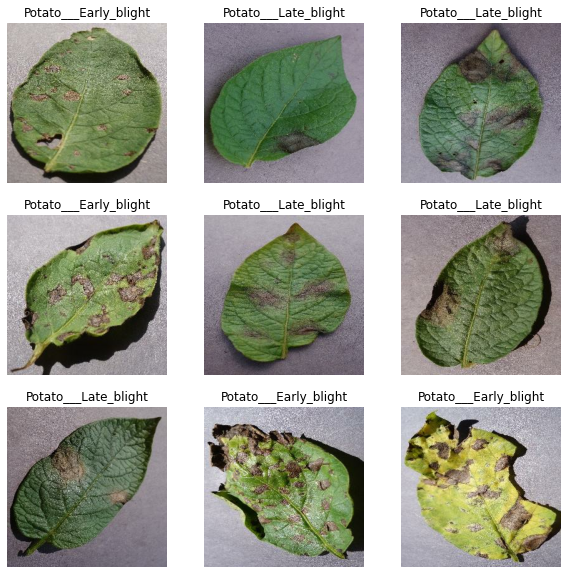

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Checking Batch Size

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


#### Checking what is the expected dimension order for channel

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [12]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [13]:
# model = models.Sequential([
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),   
# ])
# model.build(input_shape=batch_input_shape)

### Model Summary

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/10
54/54 [==============================] - 65s 1s/step - loss: 0.8914 - accuracy: 0.4730 - val_loss: 0.8342 - val_accuracy: 0.4635
Epoch 2/10
54/54 [==============================] - 56s 1s/step - loss: 0.7219 - accuracy: 0.6315 - val_loss: 0.7858 - val_accuracy: 0.6094
Epoch 3/10
54/54 [==============================] - 61s 1s/step - loss: 0.5756 - accuracy: 0.7523 - val_loss: 0.5760 - val_accuracy: 0.7500
Epoch 4/10
54/54 [==============================] - 61s 1s/step - loss: 0.4332 - accuracy: 0.8204 - val_loss: 0.6267 - val_accuracy: 0.7240
Epoch 5/10
54/54 [==============================] - 57s 1s/step - loss: 0.3594 - accuracy: 0.8586 - val_loss: 0.2741 - val_accuracy: 0.8698
Epoch 6/10
54/54 [==============================] - 57s 1s/step - loss: 0.2917 - accuracy: 0.8979 - val_loss: 0.3529 - val_accuracy: 0.8646
Epoch 7/10
54/54 [==============================] - 57s 1s/step - loss: 0.3486 - accuracy: 0.8697 - val_loss: 0.1930 - val_accuracy: 0.9115
Epoch 8/10
54/54 [==

### Testing the Model

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 3s 287ms/step - loss: 0.0886 - accuracy: 0.9688
Test Accuracy: 96.88%


### Plotting the Accuracy and Loss Curves

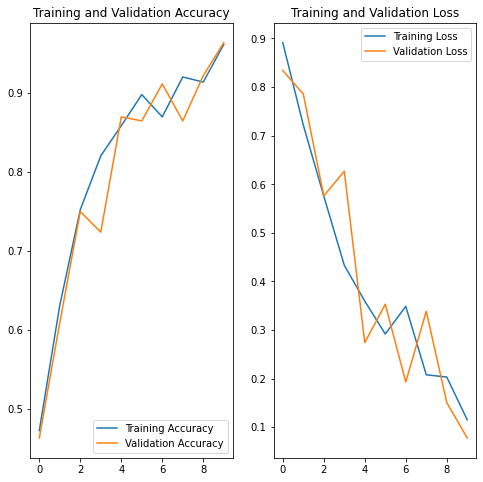

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Saving the Model
We append the model to the list of models as a new version

In [25]:
import os
model_version = max([int(i) for i in (os.listdir(r"C:\Users\shri shibi\Desktop\Potato disease classification\potato-disease-classification\saved_models")+[0])]) + 3
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/6\assets


INFO:tensorflow:Assets written to: ../models/6\assets


### Function for Inference

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Plotting the Inference Data

1/1 [==============================] - 0s 33ms/step


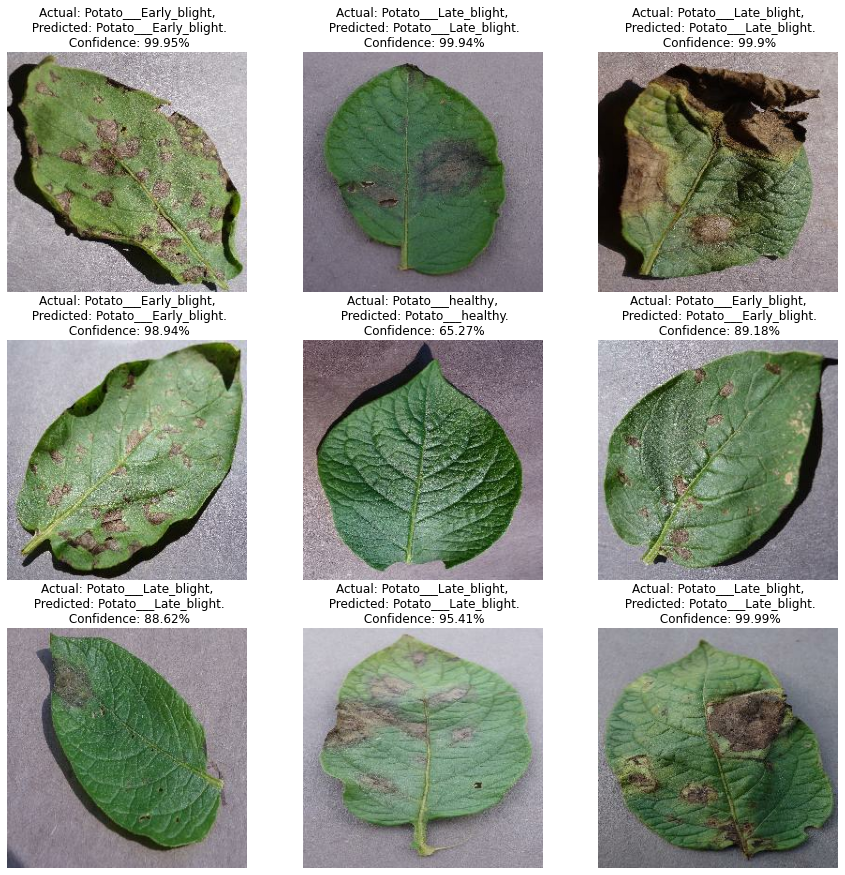

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [43]:
tf.keras.models.save_model(model,'my_model2.hdf5')

In [63]:
import gradio as gr

In [66]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}

In [67]:
image = gr.inputs.Image(shape=(256,256))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')


C:\Users\shri shibi\AppData\Roaming\Python\Python310\site-packages\gradio\inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\shri shibi\AppData\Roaming\Python\Python310\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\shri shibi\AppData\Roaming\Python\Python310\site-packages\gradio\outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\shri shibi\AppData\Roaming\Python\Python310\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 31ms/step


ERROR:pyngrok.process.ngrok:t=2022-07-31T19:42:25-0400 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=2a416960d158 clientid=a19dfba1a2dfb7a33a85067dd008d08c
2022-07-31 19:42:25.444 t=2022-07-31T19:42:25-0400 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=2a416960d158 clientid=a19dfba1a2dfb7a33a85067dd008d08c
ERROR:pyngrok.process.ngrok:t=2022-07-31T19:42:25-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=ff36944ebc6d err="session closed"
2022-07-31 19:42:25.445 t=2022-07-31T19:42:25-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=ff36944ebc6d err="session closed"
ERROR:pyngrok.process.ngrok:t=2022-07-31T19:42:25-0400 lvl=eror msg="failed to reconnect session" obj=csess id=ff36944ebc6d err="dial tcp: lookup tunnel.us.ngrok.com: no such host"
2022-07-31 19:42:25.447 t=2022-07-31T19:42:25-0400 lvl=eror msg="failed to reconnect session" obj=csess id=ff36944ebc6d err="dial tcp: lookup tunnel.us.ngrok.c

1/1 [==============================] - 0s 32ms/step


ERROR:pyngrok.process.ngrok:t=2022-07-31T20:56:41-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=ff36944ebc6d err="read EOF from remote peer"
2022-07-31 20:56:41.319 t=2022-07-31T20:56:41-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=ff36944ebc6d err="read EOF from remote peer"
INFO:pyngrok.process.ngrok:t=2022-07-31T20:56:41-0400 lvl=info msg="tunnel session started" obj=tunnels.session
2022-07-31 20:56:41.465 t=2022-07-31T20:56:41-0400 lvl=info msg="tunnel session started" obj=tunnels.session
INFO:pyngrok.process.ngrok:t=2022-07-31T20:56:41-0400 lvl=info msg="client session established" obj=csess id=ff36944ebc6d
2022-07-31 20:56:41.548 t=2022-07-31T20:56:41-0400 lvl=info msg="client session established" obj=csess id=ff36944ebc6d
ERROR:pyngrok.process.ngrok:t=2022-07-31T20:56:44-0400 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=91bc7c9a7d27 clientid=a19dfba1a2dfb7a33a85067dd008d08c
2022-07-31 20:56:44.161 t=202